In [19]:
import time
from time import sleep
import adi
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from timeit import default_timer as timer
import phaser.mycn0566 as mycn0566
CN0566=mycn0566.CN0566

In [20]:
phaserurladdress = "ip:phaser.local" #urladdress #"ip:pluto.local"
ad9361urladdress = "ip:phaser.local:50901"
Rx_CHANNEL = 2

In [21]:
# Read back properties from hardware https://analogdevicesinc.github.io/pyadi-iio/devices/adi.ad936x.html
def printSDRproperties(sdr):
    print("Bandwidth of TX path:", sdr.tx_rf_bandwidth) #Bandwidth of front-end analog filter of TX path
    print("Loopback:", sdr.loopback) #0: disable, 1: Digital TX → Digital RX, 2: RF RX → RF TX
    print("TX gain chan0:", sdr.tx_hardwaregain_chan0) #Attenuation applied to TX path, -30
    print("TX gain chan1:", sdr.tx_hardwaregain_chan1) #Attenuation applied to TX path, -10
    print("TX enabled channels:", sdr.tx_enabled_channels) 
    print("RX enabled channels:", sdr.rx_enabled_channels)
    print("RX buffer size:", sdr.rx_buffer_size) #1024

    print("TX LO: %s" % (sdr.tx_lo)) #Carrier frequency of TX path
    print("RX LO: %s" % (sdr.rx_lo)) #Carrier frequency of RX path
    print("AGC Mode chan0:", sdr.gain_control_mode_chan0)
    print("AGC Mode chan1:", sdr.gain_control_mode_chan1)#Mode of receive path AGC. Options are: slow_attack, fast_attack, manual
    print("RX gain chan0:", sdr.rx_hardwaregain_chan0)#71
    print("RX gain chan1:", sdr.rx_hardwaregain_chan1)#71 Gain applied to RX path. Only applicable when gain_control_mode is set to ‘manual’
    print("rx_rf_bandwidth:", sdr.rx_rf_bandwidth) #4Mhz Bandwidth of front-end analog filter of RX path
    print("Sample rate:", sdr.sample_rate) #Sample rate RX and TX paths in samples per second
    print("DDS scales:", sdr.dds_scales)

In [6]:
def initPhaser(urladdress, my_sdr, Blackman=False):
    #my_phaser = adi.CN0566(uri=urladdress, sdr=my_sdr)
    my_phaser = CN0566(uri=urladdress, sdr=my_sdr)
    print("Phaser url: ", my_phaser.uri)
    print("Phaser already connected")

    # Initialize both ADAR1000s, set gains to max, and all phases to 0
    my_phaser.configure(device_mode="rx")
    my_phaser.load_gain_cal()
    my_phaser.load_phase_cal()
    for i in range(0, 8):
        my_phaser.set_chan_phase(i, 0)

    if Blackman == True:
        gain_list = [8, 34, 84, 127, 127, 84, 34, 8]  # Blackman taper
        for i in range(0, len(gain_list)):
            my_phaser.set_chan_gain(i, gain_list[i], apply_cal=True)
    else:
        # Set all antenna elements to half scale - a typical HB100 will have plenty of signal power.
        gain = 64 # 64 is about half scale
        for i in range(8):
            my_phaser.set_chan_gain(i, gain, apply_cal=False)
    
    return my_phaser

In [8]:
def initAD9361(urladdress, fs, center_freq, fft_size, Rx_CH=2, Tx_CH=2):
    # Create radio
    sdr = adi.ad9361(uri=urladdress)
    sdr.rx_rf_bandwidth = 4000000 #4MHz
    sdr.sample_rate = int(fs) #0.6Mhz

    # Configure Rx
    sdr.rx_lo = int(center_freq)  # set this to output_freq - (the freq of the HB100)
    #sdr.rx_enabled_channels = [0, 1]  # enable Rx1 (voltage0) and Rx2 (voltage1)
    # Configuration data channels
    if Rx_CH==2:
        sdr.rx_enabled_channels = [0,1] #enable two rx channel
        sdr.gain_control_mode_chan0 = "manual"  # manual or slow_attack
        sdr.gain_control_mode_chan1 = "manual"  # manual or slow_attack
        sdr.rx_hardwaregain_chan0 = int(30)  # must be between -3 and 70
        sdr.rx_hardwaregain_chan1 = int(30)  # must be between -3 and 70
    else:
        sdr.rx_enabled_channels = [0] #enables Rx0
        sdr.gain_control_mode_chan0 = "manual"  # manual or slow_attack
        sdr.rx_hardwaregain_chan0 = int(30)  # must be between -3 and 70
    sdr.rx_buffer_size = int(fft_size)
    #num_samps = 1024*100#10000 # number of samples returned per call to rx()
    #sdr.rx_buffer_size = num_samps

    # Configure Tx
    sdr.tx_lo = int(center_freq)
    if Tx_CH==2:
        sdr.tx_enabled_channels = [0, 1]
        sdr.tx_hardwaregain_chan0 = -88  # must be between 0 and -88
        sdr.tx_hardwaregain_chan1 = -0  # must be between 0 and -88
    else:
        sdr.tx_enabled_channels = [0] #enables Tx0
        sdr.tx_hardwaregain_chan0 = -0  # must be between 0 and -88
    sdr.tx_cyclic_buffer = True  # must set cyclic buffer to true for the tdd burst mode.  Otherwise Tx will turn on and off randomly
    
    # Enable TDD logic in pluto (this is for synchronizing Rx Buffer to ADF4159 TX input)
    # gpio = adi.one_bit_adc_dac(sdr_ip)
    # gpio.gpio_phaser_enable = True

    return sdr

In [22]:
import pickle
phase_cal = pickle.load(open("./phaser/phase_cal_val.pkl", "rb"))
gain_cal = pickle.load(open("./phaser/gain_cal_val.pkl", "rb"))
signal_freq = pickle.load(open("./phaser/hb100_freq_val.pkl", "rb"))
d = 0.014  # element to element spacing of the antenna

sample_rate = 30e6

In [15]:
#signal_freq = 10.5 *1e9

In [23]:
signal_freq

10390000000.0

In [24]:
phaser = CN0566(uri=phaserurladdress)

In [25]:
sdr = adi.ad9361(uri=ad9361urladdress)

In [26]:
phaser.sdr = sdr
print("PlutoSDR and CN0566 connected!")

PlutoSDR and CN0566 connected!


In [27]:
phaser.configure(device_mode="rx")

# Set all antenna elements to half scale - a typical HB100 will have plenty of signal power.
gain = 64 # 64 is about half scale
for i in range(8):
    phaser.set_chan_gain(i, gain, apply_cal=False)

# Aim the beam at boresight (zero degrees)
phaser.set_beam_phase_diff(0.0)

In [28]:
# Misc SDR settings
sdr._ctrl.debug_attrs["adi,frequency-division-duplex-mode-enable"].value = "1"
sdr._ctrl.debug_attrs["adi,ensm-enable-txnrx-control-enable"].value = "0" # Disable pin control so spi can move the states
sdr._ctrl.debug_attrs["initialize"].value = "1"
sdr.rx_enabled_channels = [0, 1] # enable Rx1 and Rx2
sdr._rxadc.set_kernel_buffers_count(1) # No stale buffers to flush
sdr.tx_hardwaregain_chan0 = int(-80) # Make sure the Tx channels are attenuated (or off)
sdr.tx_hardwaregain_chan1 = int(-80)

In [29]:
sample_rate = 30e6
sdr.sample_rate = int(sample_rate)
sdr.rx_buffer_size = int(1024)  # samples per buffer
sdr.rx_rf_bandwidth = int(10e6)  # analog filter bandwidth

In [30]:
# Manually gain (no automatic gain control) so that we can sweep angle and see peaks/nulls
sdr.gain_control_mode_chan0 = "manual"
sdr.gain_control_mode_chan1 = "manual"
sdr.rx_hardwaregain_chan0 = 10 # dB, 0 is the lowest gain.  the HB100 is pretty loud
sdr.rx_hardwaregain_chan1 = 10 # dB

In [31]:
sdr.rx_lo = int(2.2e9) # 2.2GHz The Pluto will tune to this freq

In [32]:
# Set the Phaser's PLL (the ADF4159 onboard) to downconvert the HB100 to 2.2 GHz plus a small offset
offset = 1000000 # add a small arbitrary offset just so we're not right at 0 Hz where there's a DC spike
currentfreq = int(signal_freq + sdr.rx_lo - offset)
print(currentfreq)
phaser.lo = currentfreq

12589000000


In [33]:
printSDRproperties(sdr)

Bandwidth of TX path: 18000000
Loopback: 0
TX gain chan0: -80
TX gain chan1: -80
TX enabled channels: [0, 1]
RX enabled channels: [0, 1]
RX buffer size: 1024
TX LO: 2449999998
RX LO: 2200000000
AGC Mode chan0: manual
AGC Mode chan1: manual
RX gain chan0: 10
RX gain chan1: 10
rx_rf_bandwidth: 10000000
Sample rate: 29999999
DDS scales: ['0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']


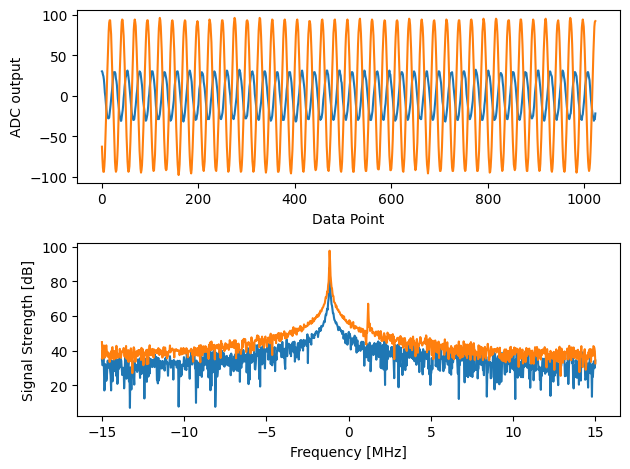

In [34]:
# Grab some samples (whatever we set rx_buffer_size to), remember we are receiving on 2 channels at the same time
data = sdr.rx()

# Take FFT
PSD0 = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(data[0])))**2)
PSD1 = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(data[1])))**2)
f = np.linspace(-sample_rate/2, sample_rate/2, len(data[0]))

# Time plot helps us check that we see the HB100 and that we're not saturated (ie gain isnt too high)
plt.subplot(2, 1, 1)
plt.plot(data[0].real) # Only plot real part
plt.plot(data[1].real)
plt.xlabel("Data Point")
plt.ylabel("ADC output")

# PSDs show where the HB100 is and verify both channels are working
plt.subplot(2, 1, 2)
plt.plot(f/1e6, PSD0)
plt.plot(f/1e6, PSD1)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Signal Strength [dB]")
plt.tight_layout()
plt.show()

C:\Users\lkk68\AppData\Local\Temp\ipykernel_7952\3593182555.py:5: RuntimeWarning: divide by zero encountered in log10
  PSD0 = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(data[0])))**2)
C:\Users\lkk68\AppData\Local\Temp\ipykernel_7952\3593182555.py:6: RuntimeWarning: divide by zero encountered in log10
  PSD1 = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(data[1])))**2)


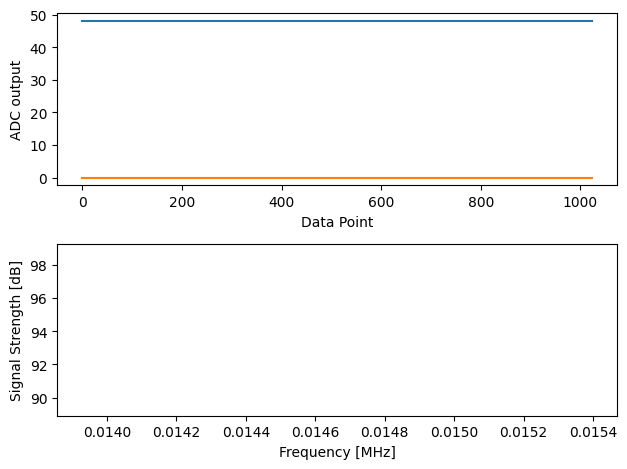

In [75]:
# Grab some samples (whatever we set rx_buffer_size to), remember we are receiving on 2 channels at the same time
data = sdr.rx()

# Take FFT
PSD0 = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(data[0])))**2)
PSD1 = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(data[1])))**2)
f = np.linspace(-sample_rate/2, sample_rate/2, len(data[0]))

# Time plot helps us check that we see the HB100 and that we're not saturated (ie gain isnt too high)
plt.subplot(2, 1, 1)
plt.plot(data[0].real) # Only plot real part
plt.plot(data[1].real)
plt.xlabel("Data Point")
plt.ylabel("ADC output")

# PSDs show where the HB100 is and verify both channels are working
plt.subplot(2, 1, 2)
plt.plot(f/1e6, PSD0)
plt.plot(f/1e6, PSD1)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Signal Strength [dB]")
plt.tight_layout()
plt.show()

In [28]:
len(data)

2

![phasebeam.png](phasebeam.png)

-180
-178
-176
-174
-172
-170
-168
-166
-164
-162
-160
-158
-156
-154
-152
-150
-148
-146
-144
-142
-140
-138
-136
-134
-132
-130
-128
-126
-124
-122
-120
-118
-116
-114
-112
-110
-108
-106
-104
-102
-100
-98
-96
-94
-92
-90
-88
-86
-84
-82
-80
-78
-76
-74
-72
-70
-68
-66
-64
-62
-60
-58
-56
-54
-52
-50
-48
-46
-44
-42
-40
-38
-36
-34
-32
-30
-28
-26
-24
-22
-20
-18
-16
-14
-12
-10
-8
-6
-4
-2
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178


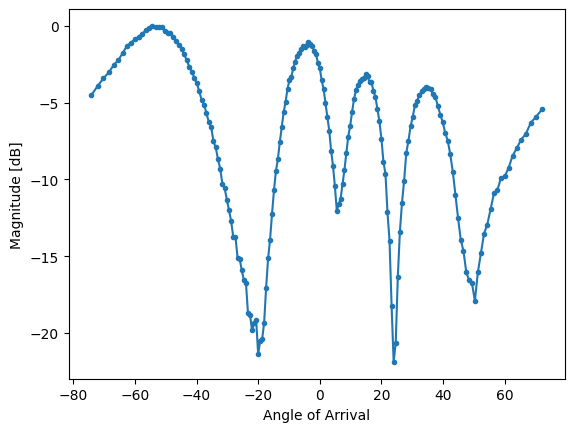

In [41]:
powers = [] # main DOA result
angle_of_arrivals = []
for phase in np.arange(-180, 180, 2): # sweep over angle
    print(phase)
    # set phase difference between the adjacent channels of devices
    for i in range(8):
        channel_phase = (phase * i + phase_cal[i]) % 360.0 # Analog Devices had this forced to be a multiple of phase_step_size (2.8125 or 360/2**6bits) but it doesn't seem nessesary
        phaser.elements.get(i + 1).rx_phase = channel_phase
    phaser.latch_rx_settings() # apply settings

    steer_angle = np.degrees(np.arcsin(max(min(1, (3e8 * np.radians(phase)) / (2 * np.pi * signal_freq * phaser.element_spacing)), -1))) # arcsin argument must be between 1 and -1, or numpy will throw a warning
    # If you're looking at the array side of Phaser (32 squares) then add a *-1 to steer_angle
    angle_of_arrivals.append(steer_angle)
    data = phaser.sdr.rx() # receive a batch of samples
    data_sum = data[0] + data[1] # sum the two subarrays (within each subarray the 4 channels have already been summed)
    power_dB = 10*np.log10(np.sum(np.abs(data_sum)**2))
    powers.append(power_dB)
    # in addition to just taking the power in the signal, we could also do the FFT then grab the value of the max bin, effectively filtering out noise, results came out almost exactly the same in my tests
    #PSD = 10*np.log10(np.abs(np.fft.fft(data_sum * np.blackman(len(data_sum))))**2) # in dB

powers -= np.max(powers) # normalize so max is at 0 dB

plt.plot(angle_of_arrivals, powers, '.-')
plt.xlabel("Angle of Arrival")
plt.ylabel("Magnitude [dB]")
plt.show()

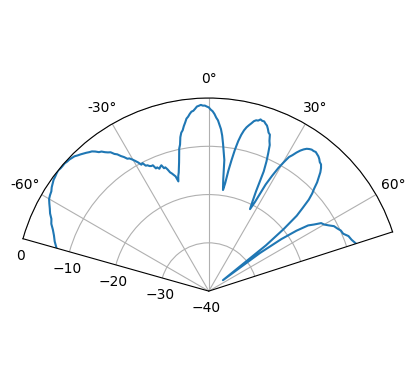

In [39]:
# Polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(np.deg2rad(angle_of_arrivals), powers) # x axis in radians
ax.set_rticks([-40, -30, -20, -10, 0])  # Less radial ticks
ax.set_thetamin(np.min(angle_of_arrivals)) # in degrees
ax.set_thetamax(np.max(angle_of_arrivals))
ax.set_theta_direction(-1) # increase clockwise
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.grid(True)
plt.show()

Starting, use control-c to stop


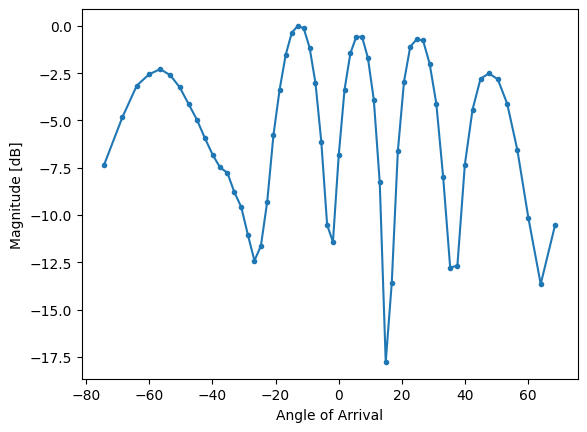

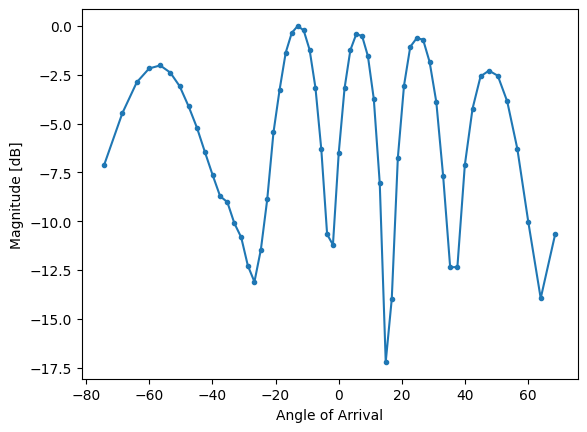

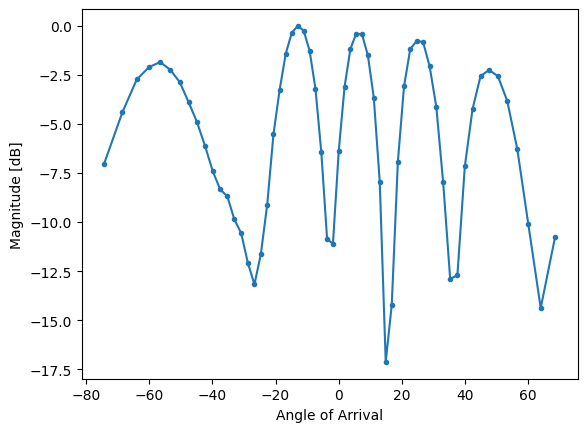

AttributeError: 'tuple' object has no attribute 'tb_frame'

<Figure size 640x480 with 0 Axes>

In [54]:
import sys
plt.ion() # needed for realtime view
print("Starting, use control-c to stop")
try:
    while True:
        powers = [] # main DOA result
        angle_of_arrivals = []
        for phase in np.arange(-180, 180, 6): # sweep over angle
            # set phase difference between the adjacent channels of devices
            for i in range(8):
                channel_phase = (phase * i + phase_cal[i]) % 360.0 # Analog Devices had this forced to be a multiple of phase_step_size (2.8125 or 360/2**6bits) but it doesn't seem nessesary
                phaser.elements.get(i + 1).rx_phase = channel_phase

            # set gains, incl the gain_cal, which can be used to apply a taper.  try out each one!
            gain_list = [127] * 8 # rectangular window          [127, 127, 127, 127, 127, 127, 127, 127]
            #gain_list = np.rint(np.hamming(8) * 127)         # [ 10,  32,  82, 121, 121,  82,  32,  10]
            #gain_list = np.rint(np.hanning(10)[1:-1] * 127)  # [ 15,  52,  95, 123, 123,  95,  52,  15]
            #gain_list = np.rint(np.blackman(10)[1:-1] * 127) # [  6,  33,  80, 121, 121,  80,  33,   6]
            #gain_list = np.rint(np.bartlett(10)[1:-1] * 127) # [ 28,  56,  85, 113, 113,  85,  56,  28]
            for i in range(8):
                channel_gain = int(gain_list[i] * gain_cal[i])
                phaser.elements.get(i + 1).rx_gain = channel_gain

            phaser.latch_rx_settings() # apply settings

            steer_angle = np.degrees(np.arcsin(max(min(1, (3e8 * np.radians(phase)) / (2 * np.pi * signal_freq * phaser.element_spacing)), -1))) # arcsin argument must be between 1 and -1, or numpy will throw a warning
            angle_of_arrivals.append(steer_angle)
            data = phaser.sdr.rx() # receive a batch of samples
            data_sum = data[0] + data[1] # sum the two subarrays (within each subarray the 4 channels have already been summed)
            power_dB = 10*np.log10(np.sum(np.abs(data_sum)**2))
            powers.append(power_dB)

        powers -= np.max(powers) # normalize so max is at 0 dB

        # Realtime view
        plt.plot(angle_of_arrivals, powers, '.-')
        plt.xlabel("Angle of Arrival")
        plt.ylabel("Magnitude [dB]")
        plt.draw()
        plt.pause(0.001)
        plt.clf()

except KeyboardInterrupt:
    sys.exit() # quit python